In [1]:
import os
import os.path
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from matplotlib import pyplot
import sys
from IPython import display

In [2]:
def retrievefromdrive():
    scope = ["https://spreadsheets.google.com/feeds","https://www.googleapis.com/auth/spreadsheets","https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
    #why should I  put here the my scope?

    creds= ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)

    client=gspread.authorize(creds)


    sheet=client.open("Gorillas Nico").sheet1

    data=sheet.get_all_values()
    return data
data=retrievefromdrive()

In [3]:
df=pd.DataFrame.from_records(data)
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df.drop(df.loc[df['hrs']==''].index, inplace=True)#if I drop the hrs I drop the day I was free and not payed

In [4]:
holidays=df.loc[df['schedule']=='']
df.drop(df.loc[df['schedule']==''].index, inplace=True)#if I drop the schedule I also drop holiday
#the reaming are working days and sick days
#add a specific table to holidays to add at the end

In [5]:
df=df.apply(lambda x: x.str.replace(',','.'))

df.loc[df.deliveries=='',('cash','etips','deliveries')]=0

df.loc[df.deliveries==0]
print(len(df.loc[df.deliveries==0]))

18


In [6]:
len(df.loc[df.deliveries==0])

18

In [7]:
df['date']=pd.to_datetime(df.date,format='%d/%m/%Y')#remember to put 'year' with Y capital

df=df.astype({   #transforming every columns in a usefull type
    'schedule':'string',
    'cash': 'float',
    'etips':'float',
    'deliveries':'int',
    'hrs':'float'
    })
tips=df.cash+df.etips

In [8]:
df.loc[:133,'bonus']='1'
df.loc[133:223,'bonus']='2'
df.loc[224:529,'bonus']='3'
df.loc[531:,'bonus']='4'

In [9]:
tg=df.groupby(by=[df.date.dt.year, df.date.dt.month])#tg= time_grouper
tab=tg.deliveries.sum()/tg.hrs.sum()

In [10]:
df['year']=df.date.dt.year
df['month']=df.date.dt.month
dates = list(zip(df.year, df.month))

In [11]:
#If the time index (year and month) of a day in the dataframe is the same of the monthly Delivery per Hrs
# tab, then we append to a list those avg monthly Delivery_per_Hrs values for every day of the df.
l=[]
for i in range(len(df)):
    for el in tab.index:
        if dates[i] == el:
            l.append(tab[el])
df['monthdelhrs']=l
        
        

In [12]:
tax1=0.7809
tax2=0.7424
tax3=0.8070
def nett():
    l=[]
    for i in range(len(df)):
        d=df.iloc[i]
        if d.bonus=='1': #before bonus, minimum payment 10.5€ per hour
            net=(d.hrs*10.5)*tax1
            l.append(net)
        elif d.bonus=='2': #creation of the bonus but minimum payment still 10.5€ per hour
            if d.monthdelhrs >2.625:
                net=(d.deliveries*4)*tax2
                l.append(net)
            else:
                net=(d.hrs*10.5)*tax1
                l.append(net)
        elif d.bonus=='3': #minimum payment raised to 12€ per hour
            if d.monthdelhrs >3:
                net=(d.deliveries*4)*tax2
                l.append(net)
            else:
                net=(d.hrs*12)*tax1
                l.append(net)
        elif d.bonus=='4': #partime 20 hour per week, less income, different taxation
            if d.monthdelhrs >3:
                if d.hrs<95:
                    net=(d.deliveries*4)*tax3
                    l.append(net)
                else:
                    net=(d.deliveries*4)*tax2
                    l.append(net)

            else:
                net=(d.hrs*12)*tax3
                l.append(net)

            
    return l
df['net']=nett()  

In [13]:
tips=df.cash+df.etips
df['net']=df.net+tips

In [14]:
ho=holidays
ho['date']=pd.to_datetime(ho.date,format='%d/%m/%Y')
ho['hrs']=ho[['hrs']].astype(int)
hg=ho.groupby(by=[ho.date.dt.year, ho.date.dt.month])
ho.loc[:204:,'net']=(ho.hrs*10.5)*0.77
ho.loc[311:,'net']=(ho.hrs*12)*0.77

In [15]:
totaldel=tg.deliveries.sum()
totaltips=tg.etips.sum()
totalcash=tg.cash.sum()
totalnet=tg.net.sum().add(hg.net.sum(), fill_value=0) #working +tips +sick + holiday (per month)
totalhrs=tg.hrs.sum().add(hg.hrs.sum(), fill_value=0) #fillvalue avoids Nan results

totalcash+totaltips

date  date
2021  5        95.70
      6       277.70
      7       210.40
      8       144.35
      9       296.40
      10      253.00
      11      495.20
      12      112.00
2022  1       541.50
      2       259.00
      3       163.30
      4       251.20
      5       187.10
      6       255.60
      7       484.93
      8       367.00
      9       496.50
      10      224.80
      11      331.90
      12      337.00
2023  1       467.90
      2       240.30
      3       158.50
      4       265.10
      5       172.00
dtype: float64

In [16]:
totalcash

date  date
2021  5        26.70
      6        81.70
      7        82.40
      8        49.35
      9        98.40
      10       87.00
      11      174.20
      12       24.00
2022  1       158.50
      2        48.00
      3        39.30
      4        78.20
      5        59.10
      6        76.10
      7       123.60
      8        77.50
      9       146.50
      10       52.80
      11       91.90
      12       73.00
2023  1       122.90
      2        52.30
      3        44.50
      4        77.10
      5        56.00
Name: cash, dtype: float64

In [17]:
totaldel

date  date
2021  5        92
      6       241
      7       174
      8       150
      9       276
      10      257
      11      464
      12       82
2022  1       415
      2       227
      3       148
      4       231
      5       171
      6       213
      7       450
      8       336
      9       467
      10      211
      11      324
      12      247
2023  1       356
      2       212
      3       159
      4       276
      5       133
Name: deliveries, dtype: int64

In [18]:
totalnet

date  date
2021  5        423.678000
      6       1343.628500
      7       1022.145550
      8        977.832650
      9       1239.336750
      10      1216.435375
      11      1873.094400
      12       945.974617
2022  1       1773.884000
      2       1169.654344
      3       1238.794540
      4       1303.449088
      5       1209.932600
      6       1224.447012
      7       1821.250000
      8       1595.785600
      9       1929.503200
      10      1313.385600
      11      1377.772000
      12      1134.316000
2023  1       1617.068000
      2       1072.476000
      3       1015.146640
      4       1340.828000
      5        714.304000
Name: net, dtype: float64

In [19]:
totalhrs

date  date
2021  5        40.00
      6       130.00
      7        99.00
      8       102.00
      9       115.00
      10      117.50
      11      123.49
      12      102.06
2022  1       114.68
      2        97.18
      3       115.05
      4       112.36
      5       109.50
      6       103.39
      7       114.86
      8       111.78
      9       117.84
      10      105.96
      11       96.32
      12       67.77
2023  1       103.55
      2        75.49
      3        88.46
      4       101.90
      5        56.00
Name: hrs, dtype: float64

In [20]:
totalnet/totalhrs

date  date
2021  5       10.591950
      6       10.335604
      7       10.324703
      8        9.586595
      9       10.776841
      10      10.352641
      11      15.167984
      12       9.268809
2022  1       15.468120
      2       12.035957
      3       10.767445
      4       11.600650
      5       11.049613
      6       11.842993
      7       15.856260
      8       14.276128
      9       16.373924
      10      12.395108
      11      14.304111
      12      16.737731
2023  1       15.616301
      2       14.206862
      3       11.475770
      4       13.158273
      5       12.755429
dtype: float64

In [21]:
bustapaga=totalnet-tg.cash.sum()
bustapaga+15

date  date
2021  5        411.978000
      6       1276.928500
      7        954.745550
      8        943.482650
      9       1155.936750
      10      1144.435375
      11      1713.894400
      12       936.974617
2022  1       1630.384000
      2       1136.654344
      3       1214.494540
      4       1240.249088
      5       1165.832600
      6       1163.347012
      7       1712.650000
      8       1533.285600
      9       1798.003200
      10      1275.585600
      11      1300.872000
      12      1076.316000
2023  1       1509.168000
      2       1035.176000
      3        985.646640
      4       1278.728000
      5        673.304000
dtype: float64

In [22]:
def yearcomparison(totalnet,x,z):
    tn=totalnet.to_frame()
    tn=tn.reset_index(level=1)
    tn.rename(columns={'date': 'month'}, inplace=True)
    tn=tn.reset_index()
    tn.rename(columns={'date': 'year'}, inplace=True)
    gfp = pd.pivot_table(data=tn, index='month', columns='year', values=x, aggfunc='sum')
    ax = gfp.plot(kind='bar', ylabel='Aggregated Sum', figsize=(12, 6), rot=0)
    ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
    plt.title(z,fontsize=22,loc='left')
    plt.grid()

# Performance analysis

In [23]:
df.drop(df.loc[df['deliveries']==0].index, inplace=True)#I analyse only day I was riding:
#no holiday and no sick leaves
df['tips']=df.cash+df.etips

In [24]:
def plot(y,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(df.date,y, color='darkblue',label=z)
    plt.title(z)
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend()
    plt.show()


In [79]:
import matplotlib.ticker as mticker 
def barplot(y,z):
    fig, ax = plt.subplots(figsize=(13,7))
    color,line=[],[]
    for el in y:
        if el >2:
            color.append('green')
            line.append(1.5)
        elif el<-1:
            color.append('red')
            line.append(1.5)
        else:
            color.append('grey')
            line.append(1.5)
    ax.bar(df.date,y,width=0.7,color=color,edgecolor='black',linewidth=line,label=z)
    ax.axhline(0, linestyle='--', color='k') 
    ax.axhline(y.mean(),linestyle='--', color='g')
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f €/h'))
    plt.title(z,fontsize=22,loc='left')
    plt.xticks(rotation=70)
    fig.savefig("Daily_amount_net_bonus_July.pdf",bbox_inches='tight',pad_inches=0)
    # gca() function in pyplot module of matplotlib library is used to get the current Axes
    plt.show()
    print(round(y.mean(),2))
          
df.loc[(df.month==11)&(df.year==2021),'bonusdifnov']=(df.net/df.hrs)-(12)
df.loc[(df.month==1)&(df.year==2022),'bonusdifjan']=(df.net/df.hrs)-(12)
df.loc[(df.month==7)&(df.year==2022),'bonusdifjul']=(df.net/df.hrs)-(12)
df.loc[(df.month==8)&(df.year==2022),'bonusdifaug']=(df.net/df.hrs)-(12)
df.loc[(df.month==9)&(df.year==2022),'bonusdifsep']=(df.net/df.hrs)-(12)
df.loc[(df.month==10)&(df.year==2022),'bonusdifoct']=(df.net/df.hrs)-(12)
df.loc[(df.month==11)&(df.year==2022),'bonusdifnov2']=(df.net/df.hrs)-(12)
df.loc[(df.month==12)&(df.year==2022),'bonusdifdec']=(df.net/df.hrs)-(12)
df.loc[(df.month==1)&(df.year==2023),'bonusdifjan2']=(df.net/df.hrs)-(12)
df.loc[(df.month==2)&(df.year==2023),'bonusdiffeb']=(df.net/df.hrs)-(12)
df.loc[(df.month==3)&(df.year==2023),'bonusdifmarch']=(df.net/df.hrs)-(12)
df.loc[(df.month==4)&(df.year==2023),'bonusdifapr']=(df.net/df.hrs)-(12)
df.loc[(df.month==5)&(df.year==2023),'bonusdifmag']=(df.net/df.hrs)-(12)


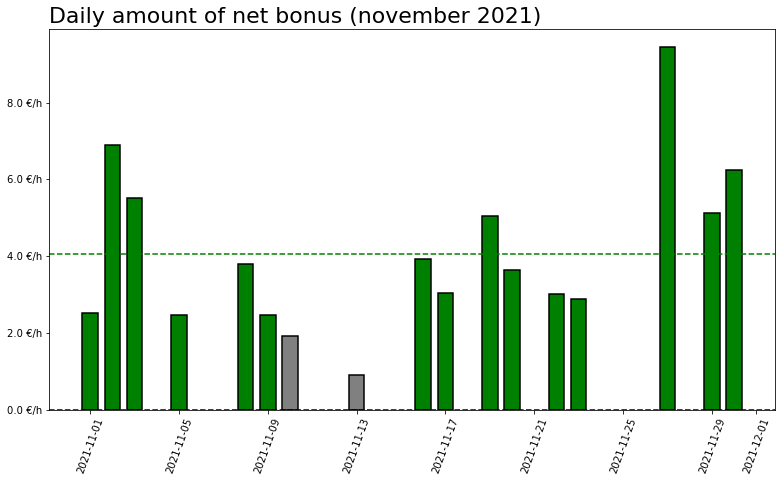

4.05
481.21


In [80]:
barplot(df.bonusdifnov,'Daily amount of net bonus (november 2021)')
month=df.loc[(df.month==11)&(df.year==2021)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

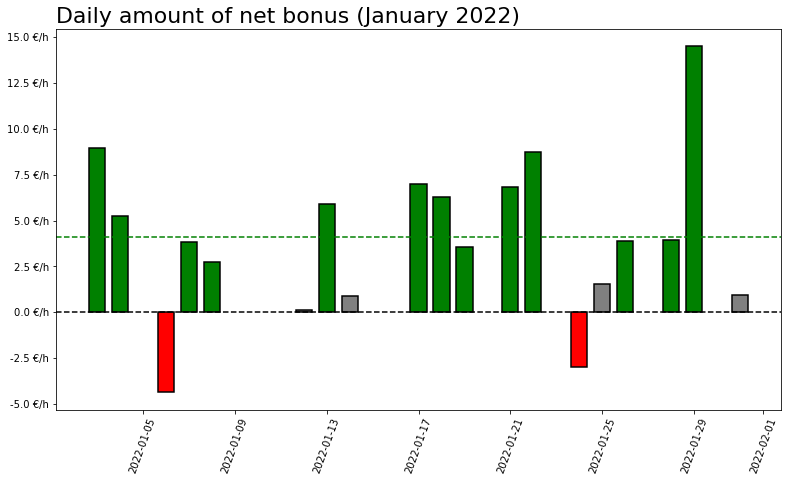

4.08
457.72


In [81]:
barplot(df.bonusdifjan,'Daily amount of net bonus (January 2022)')
month=df.loc[(df.month==1)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

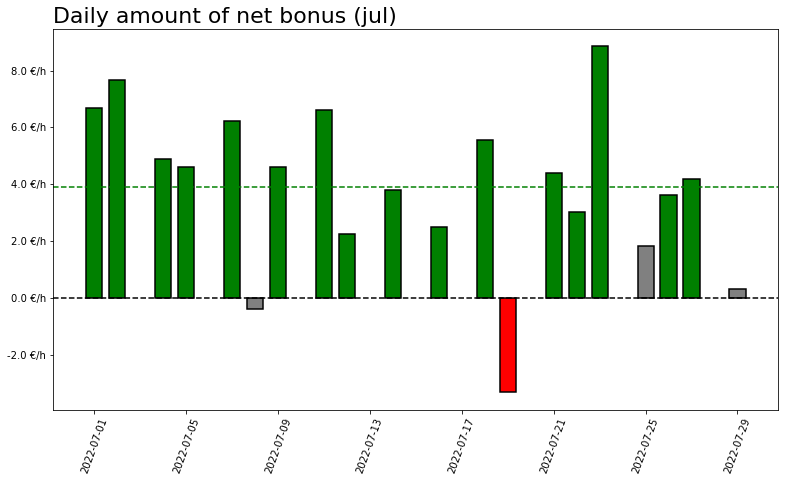

3.89
500.36


In [77]:
barplot(df.bonusdifjul,'Daily amount of net bonus (jul)')
month=df.loc[(df.month==7)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

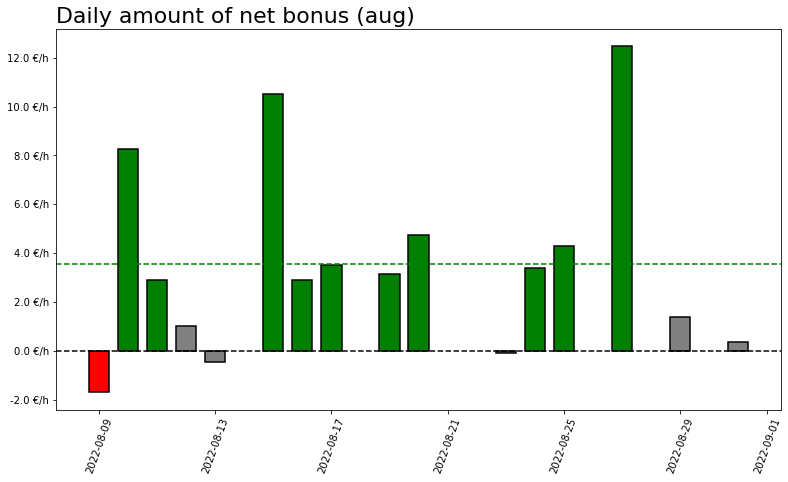

3.55
323.43


In [68]:
barplot(df.bonusdifaug,'Daily amount of net bonus (aug)')
month=df.loc[(df.month==8)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

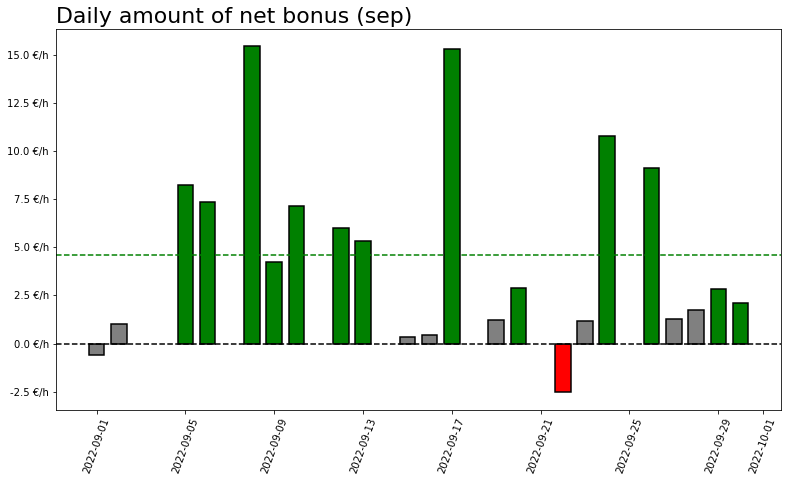

4.58
529.22


In [69]:
barplot(df.bonusdifsep,'Daily amount of net bonus (sep)')
month=df.loc[(df.month==9)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

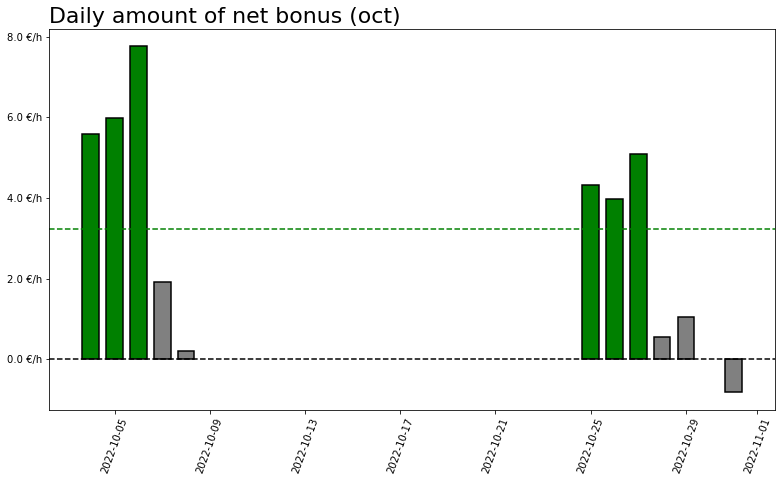

3.24
179.87


In [70]:
barplot(df.bonusdifoct,'Daily amount of net bonus (oct)')
month=df.loc[(df.month==10)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

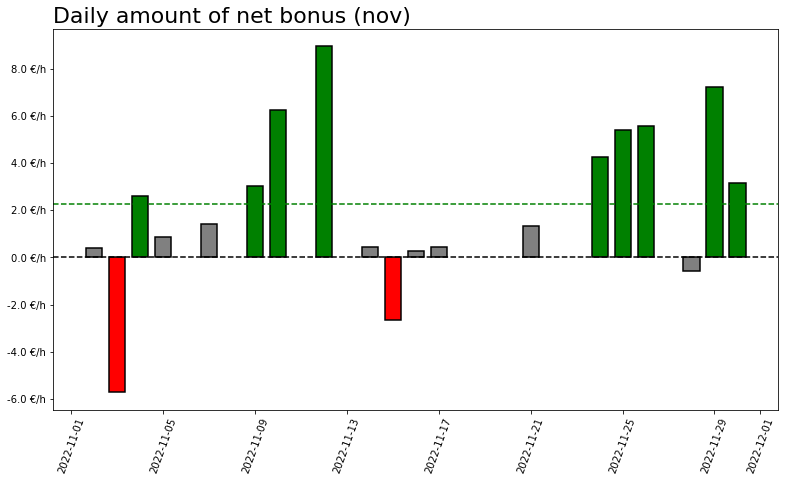

2.25
221.93


In [71]:
barplot(df.bonusdifnov2,'Daily amount of net bonus (nov)')
month=df.loc[(df.month==11)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

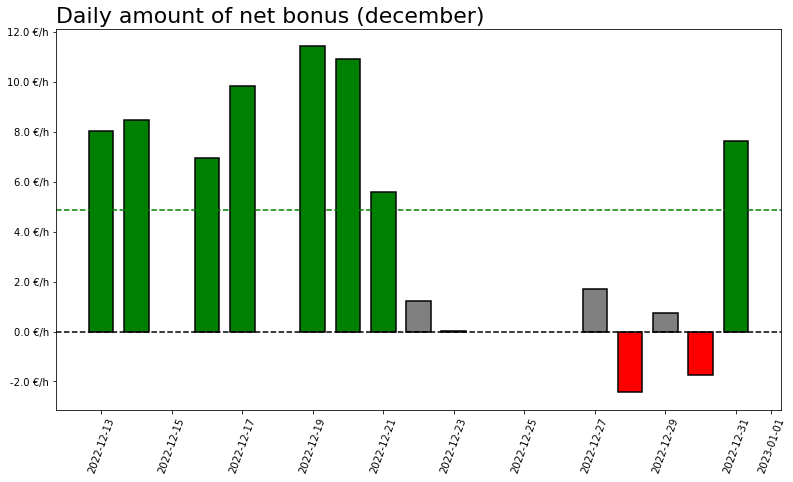

4.88
321.08


In [72]:
barplot(df.bonusdifdec,'Daily amount of net bonus (december)')
month=df.loc[(df.month==12)&(df.year==2022)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

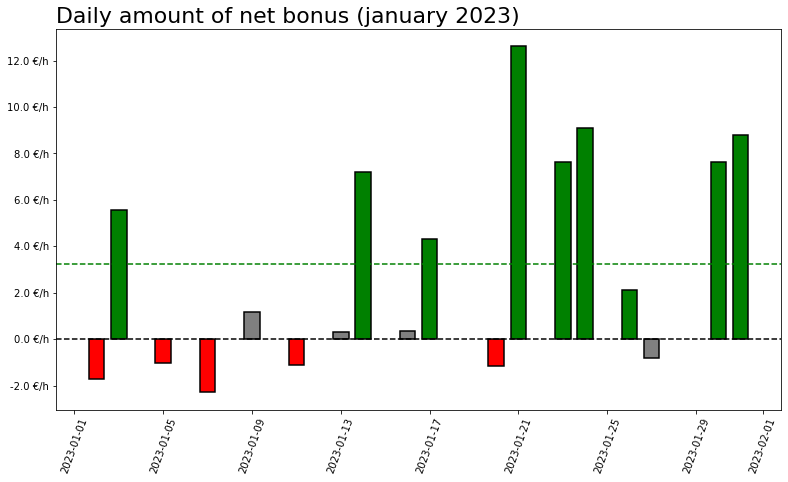

3.26
374.47


In [73]:
barplot(df.bonusdifjan2,'Daily amount of net bonus (january 2023)')
month=df.loc[(df.month==1)&(df.year==2023)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

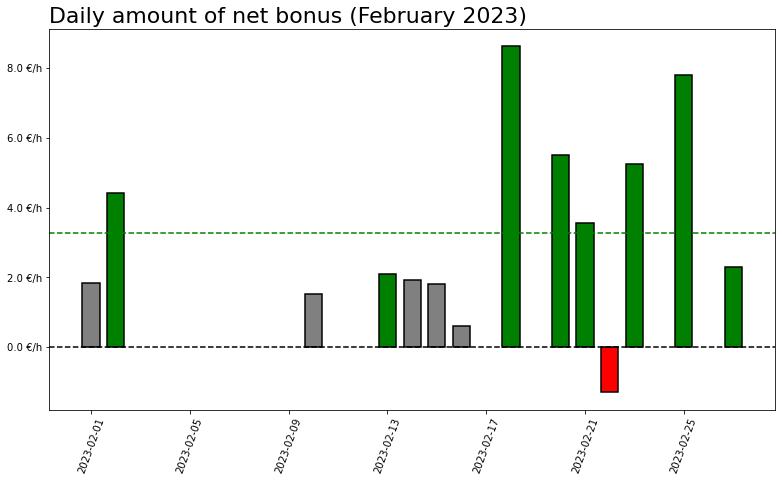

3.28
210.76


In [82]:
barplot(df.bonusdiffeb,'Daily amount of net bonus (February 2023)')
month=df.loc[(df.month==2)&(df.year==2023)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

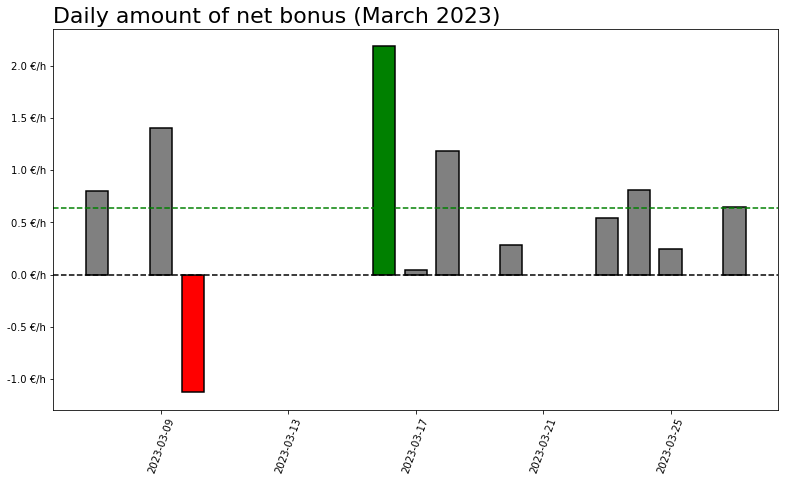

0.64
34.69


In [74]:
barplot(df.bonusdifmarch,'Daily amount of net bonus (March 2023)')
month=df.loc[(df.month==3)&(df.year==2023)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

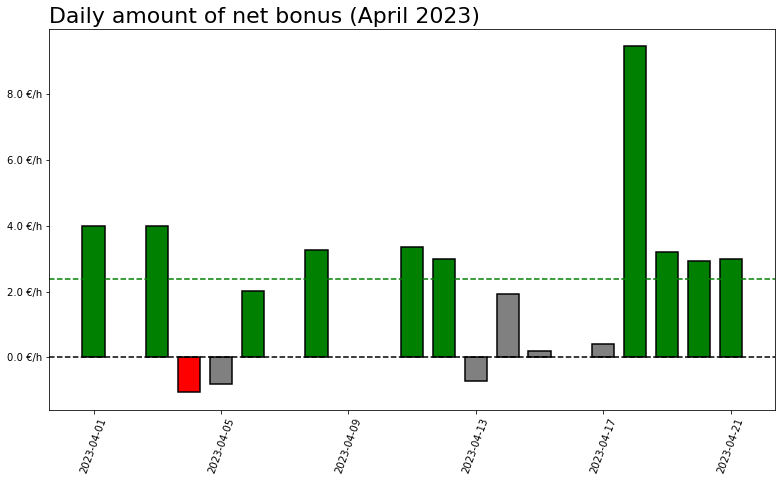

2.38
173.23


In [35]:
barplot(df.bonusdifapr,'Daily amount of net bonus (April 2023)')
month=df.loc[(df.month==4)&(df.year==2023)]
print(month)
print(round(month.net.sum()-(12*month.hrs.sum()),2))

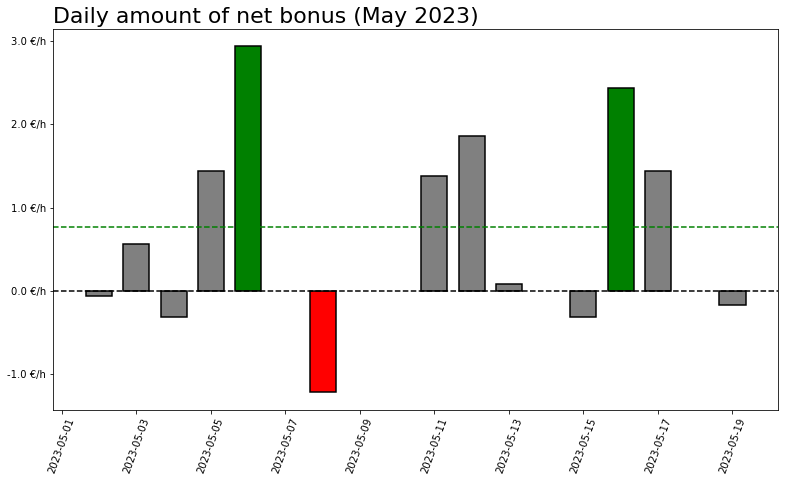

0.77
173.23


In [36]:
barplot(df.bonusdifmag,'Daily amount of net bonus (May 2023)')
month=df.loc[(df.month==4)&(df.year==2023)]
print(round(month.net.sum()-(12*month.hrs.sum()),2))

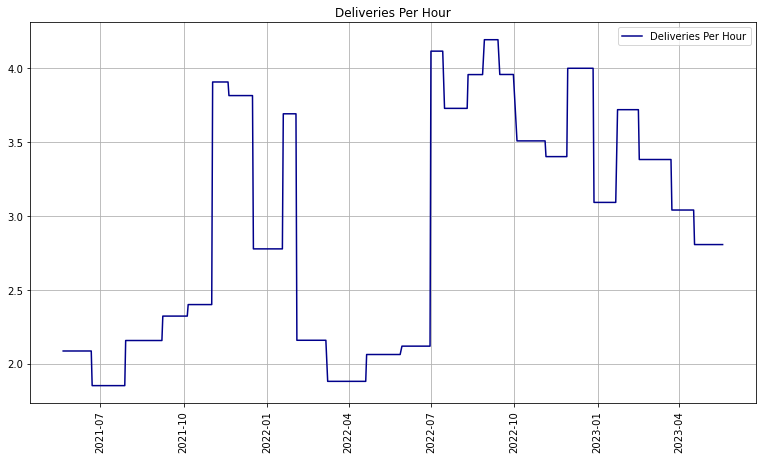

In [37]:
def grouper(v,x):
    df.group=0
    l=[]
    d,el=0,0
    for el in df.index:
        d+=x.loc[el]
        if el ==(df.index)[-1]:
            l.append(el)
            d=0
        if d>=v:
            l.append(el)
            d=0
    for el in reversed(l):
        df.loc[:el,'group']=el
    df['sumnet'] = df['net'].groupby(df['group']).transform('sum')
    df['sumhrs'] = df['hrs'].groupby(df['group']).transform('sum')
    df['sumdel'] = df['deliveries'].groupby(df['group']).transform('sum')
    df['sumcash'] = df['cash'].groupby(df['group']).transform('sum')
    df['sumtips'] = df['tips'].groupby(df['group']).transform('sum')
grouper(235,df.deliveries)
plot(df.sumdel/df.sumhrs,'Deliveries Per Hour')

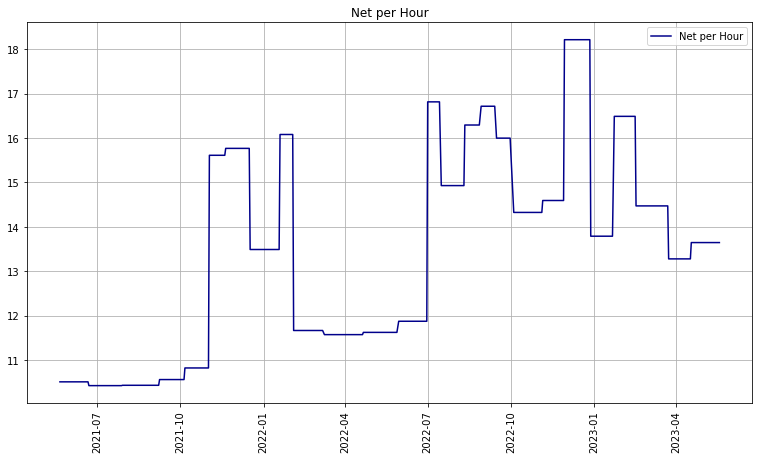

In [38]:
plot(df.sumnet/df.sumhrs,'Net per Hour')

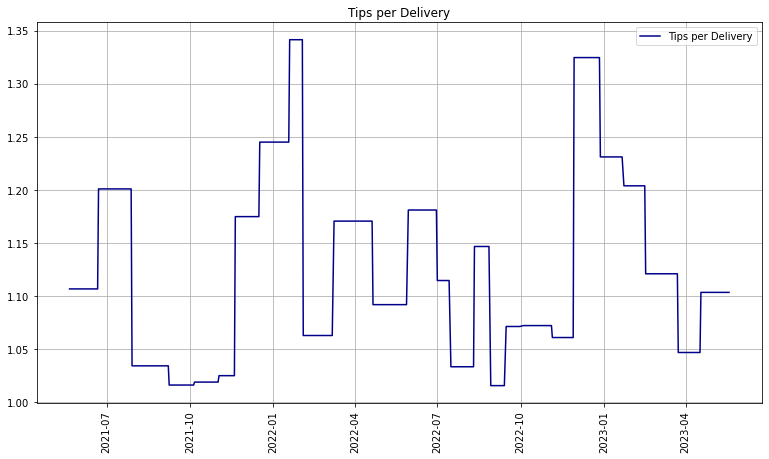

In [39]:
plot(df.sumtips/df.sumdel,'Tips per Delivery')

## Cash Ratio

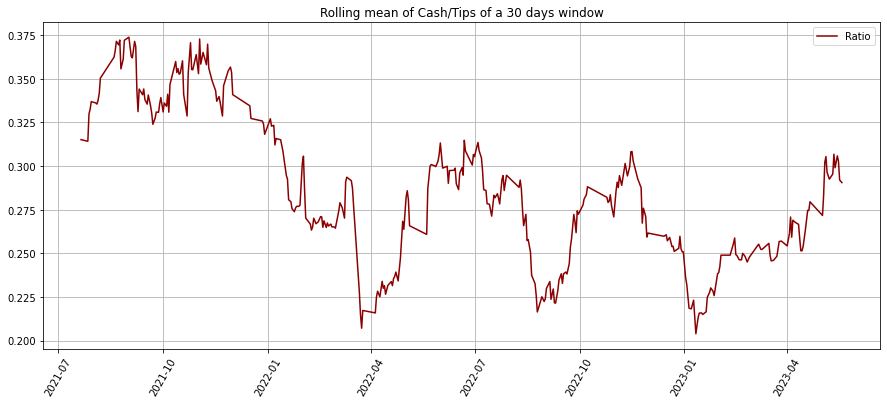

In [40]:
s,l=0,[]
for i in range(len(df.cash)-30):
    r=(range(s,s+30))
    c,t=df.cash.iloc[r],df.tips.iloc[r]
    s+=1
    l.append((c.sum()/t.sum()))
df.loc[62:,'RatioCash']=l
fig, ax = plt.subplots(figsize=(15,6)) 
ax.plot(df.date,df.RatioCash, color='darkred',label='Ratio')
plt.title('Rolling mean of Cash/Tips of a 30 days window')
plt.xticks(rotation=60)
plt.legend()
plt.grid()

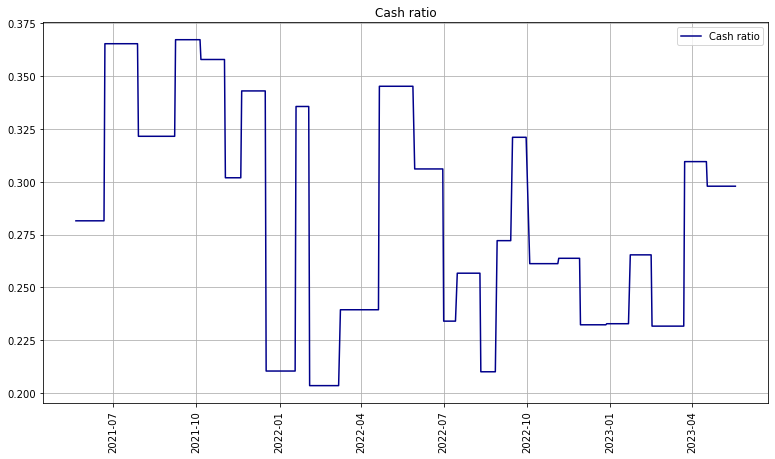

In [41]:
plot(df.sumcash/df.sumtips,'Cash ratio')

 # Comparison with year 2021

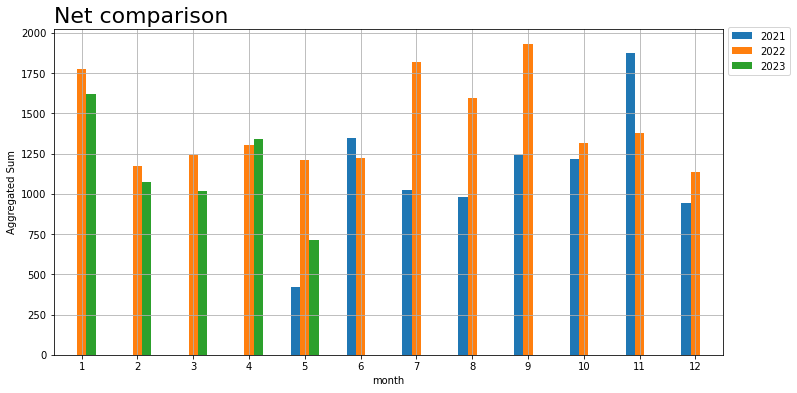

In [42]:
yearcomparison(totalnet,'net','Net comparison')

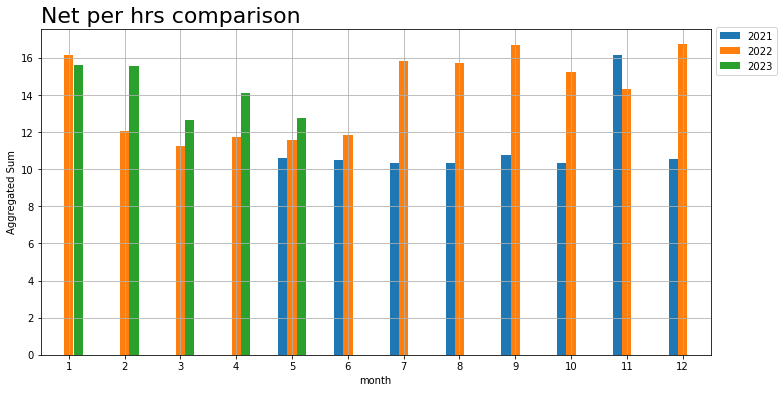

In [43]:
tg=df.groupby(by=[df.date.dt.year, df.date.dt.month])#tg=time_grouper
delhrstab=tg.net.sum()/tg.hrs.sum()
yearcomparison(delhrstab,0,'Net per hrs comparison')

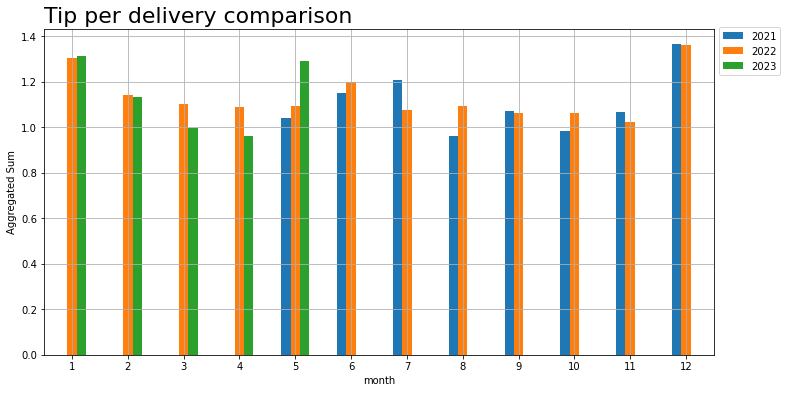

In [44]:
tipdeltab=tg.tips.sum()/tg.deliveries.sum()
yearcomparison(tipdeltab,0,'Tip per delivery comparison')

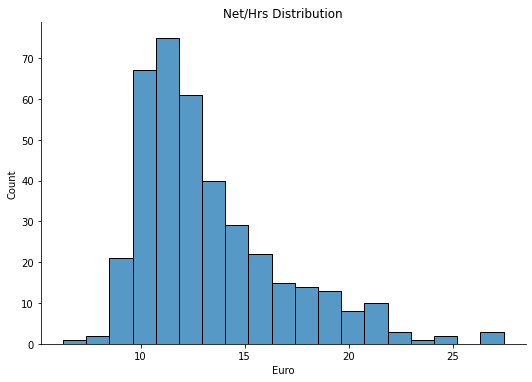

In [45]:
def distr(x,z):
    g=sns.displot(x=x, aspect=1.5)
    g.set_axis_labels("Euro")
    plt.title(z)
    plt.show()

    plt.show()
    
distr(df.net/df.hrs,'Net/Hrs Distribution')

In [46]:
(df.net/df.hrs).max()

27.423274161735698

In [47]:
df.loc[(df.net/df.hrs)==(df.net/df.hrs).max()]

,date,schedule,cash,etips,deliveries,hrs,bonus,year,month,monthdelhrs,...,bonusdifmarch,bonusdifapr,bonusdifmag,group,sumnet,sumhrs,sumdel,sumcash,sumtips,RatioCash
476,2022-09-08,17.11-23.15,12.1,23.0,35,5.07,3,2022,9,4.138603,...,NaN,NaN,NaN,481,1008.2088,60.31,253,69.9,256.9,0.229583


In [48]:
df.loc[(tips/df.deliveries)==(tips/df.deliveries).max()]

,date,schedule,cash,etips,deliveries,hrs,bonus,year,month,monthdelhrs,...,bonusdifmarch,bonusdifapr,bonusdifmag,group,sumnet,sumhrs,sumdel,sumcash,sumtips,RatioCash
722,2023-05-12,16.00-21.00,2.9,18.0,8,5.0,4,2023,5,2.375,...,NaN,NaN,1.864,729,1035.544,75.89,213,70.0,235.0,0.306801


# Cumulative

In [49]:
nethrs_inc=df['net'].cumsum()/df['hrs'].cumsum() 
tipdel_inc=df['tips'].cumsum()/df['deliveries'].cumsum()

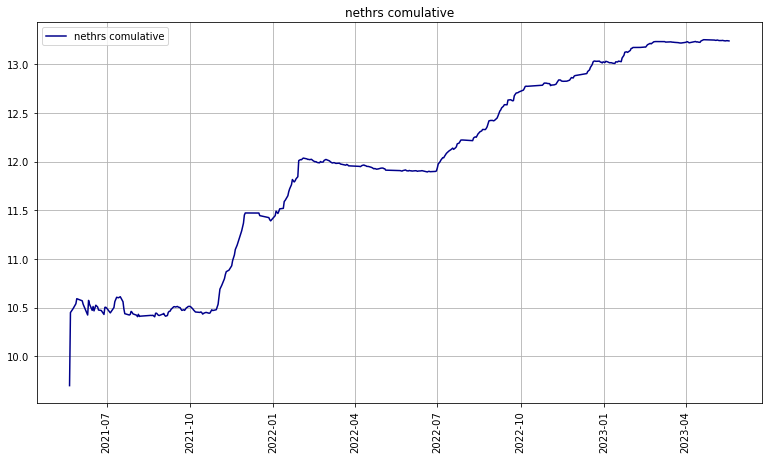

In [50]:
plot(nethrs_inc,'nethrs comulative')

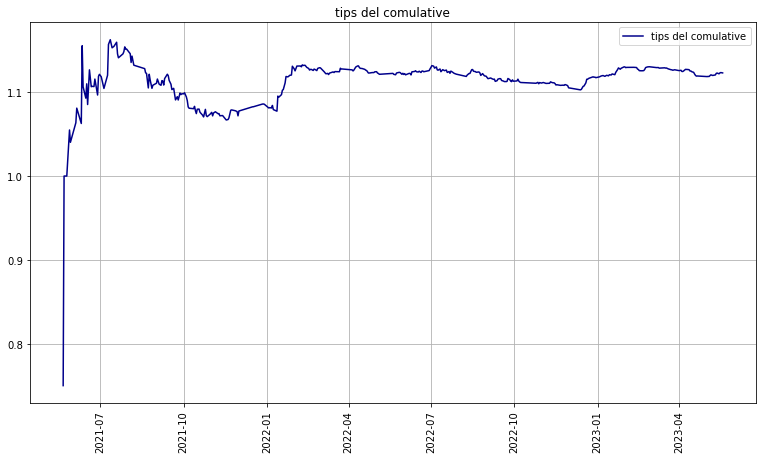

In [51]:
plot(tipdel_inc,'tips del comulative')

In [52]:
df['day']=df.date.dt.day_name()

In [53]:
#maybe it would be cool to filt by bonus and to see the difference

In [54]:
df['nethrs']=df.net/df.hrs

df['tipdel']=tips/df.deliveries

df['delhrs']=df.deliveries/df.hrs

In [55]:
(df.groupby('day')['deliveries'].sum()/df.groupby('day')['hrs'].sum()).sort_values()

day
Friday       2.525433
Thursday     2.726710
Wednesday    2.802086
Monday       2.915299
Tuesday      2.989974
Saturday     3.219657
dtype: float64

In [56]:
def typemonthfunc (val):
    if val <=7:
        a='first'
    elif 7<val<=14:
        a='second'
    elif 14<val<=21:
        a='third'
    else:
        a='fourth'
    return a
df['typemonth'] = df['date'].dt.day.apply(lambda x:typemonthfunc(x))
df['daynum'] = df['date'].dt.day

In [57]:
filt=((df.year==2022)&(df.month>6))
dfb=df[filt]

In [58]:
(dfb.groupby('typemonth')['net'].sum()/dfb.groupby('typemonth')['hrs'].sum()).sort_values()

typemonth
fourth    15.104702
first     15.696268
third     16.279113
second    16.600011
dtype: float64

In [59]:
(dfb.groupby('typemonth')['tips'].sum()/dfb.groupby('typemonth')['deliveries'].sum()).sort_values()

typemonth
fourth    1.070930
second    1.074236
first     1.095594
third     1.193396
dtype: float64

In [60]:
(dfb.groupby('day')['net'].sum()/dfb.groupby('day')['hrs'].sum()).sort_values()

day
Friday       14.081620
Thursday     15.102316
Wednesday    15.275195
Tuesday      15.351708
Monday       16.258490
Saturday     18.580586
dtype: float64

In [65]:
df['tips']=df.cash+df.etips
df_exported=df[['date','schedule','deliveries','hrs','tips']]
df_exported.to_csv(r'/home/nico/Desktop/Progetti/Rider_activity/Rider_activity.csv', index = False) #export data for minute to minut analysy

In [62]:
(dfb.groupby('typemonth')['net'].sum()/dfb.groupby('typemonth')['hrs'].sum()).sort_values()

typemonth
fourth    15.104702
first     15.696268
third     16.279113
second    16.600011
dtype: float64

In [63]:
dfb.groupby('typemonth')['net'].count()

typemonth
first     18
fourth    39
second    22
third     23
Name: net, dtype: int64